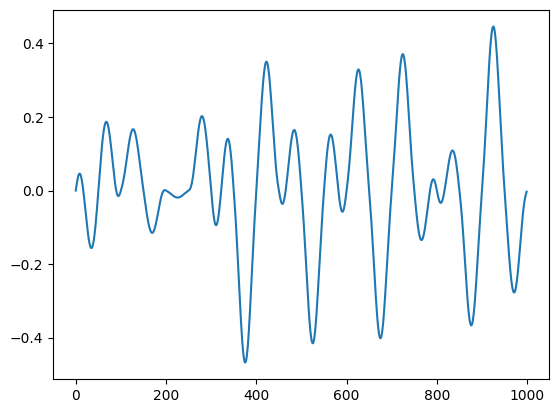

In [2]:
import matplotlib.pyplot as plt
from perlin_noise import PerlinNoise

noise = PerlinNoise(octaves=1)
for _ in range(1000):
    pic = [noise(i/50) for i in range(1000)]

plt.plot(pic)
plt.show()

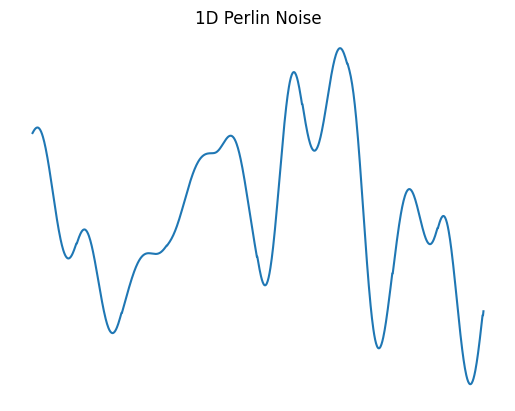

In [17]:
from pyperlin import FractalPerlin2D
import torch

shape = (1,1000,100)

g_cuda = torch.Generator(device='cuda') #for GPU acceleration

g_cuda.seed()

clouds = FractalPerlin2D(shape, [(10,10)], [5], generator=g_cuda)()

plt.plot(clouds.cpu().numpy()[0,:,0])
plt.axis('off')  # Turn off axis
plt.title('1D Perlin Noise')
plt.show()


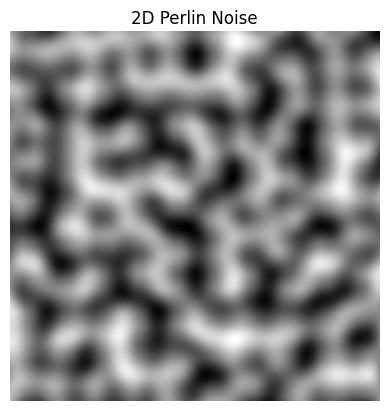

In [18]:
shape = (1,1000,1000)

g_cuda = torch.Generator(device='cuda') #for GPU acceleration

g_cuda.seed()

clouds = FractalPerlin2D(shape, [(10,10)], [5], generator=g_cuda)()

plt.imshow(clouds.cpu().numpy()[0,:,:], cmap='gray')
plt.axis('off')  # Turn off axis
plt.title('2D Perlin Noise')
plt.show()